# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 18, 23, 27, 56, 402415)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
# with open('../../data/hopsworks-api-key.txt', 'r') as file:
#    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164448
Connected. Call `.close()` to terminate connection gracefully.
api_key F6cnnnohsG10j8Om.OWUKK8CKWKr39wMmDaUe1eEtwzZWdyqUrImPdxzGkJtK0d5X1AgBesl082BHElby
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [5]:
air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality_with_lagged',
    description="weather features with air quality as the target",
    version=1,
)


In [6]:
start_day = today - datetime.timedelta(days=3)
end_day = today
air_quality_fg_filtered = air_quality_fg.filter(air_quality_fg.date >= start_day and air_quality_fg.date <= end_day ).read()
air_quality_fg_filtered = air_quality_fg_filtered.sort_values(by="date")
todays_lagged_pm_25 = air_quality_fg_filtered.loc[len(air_quality_fg_filtered)-1,"lagged_pm25"]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_with_lagged",
    version=2,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='7.004928E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [9]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data["lagged_pm25"]=todays_lagged_pm_25
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged_pm25
0,2024-11-21 00:00:00+00:00,6.30,0.0,18.032370,273.433563,athens,89.0
1,2024-11-23 00:00:00+00:00,4.25,0.0,13.684735,268.492584,athens,89.0
2,2024-11-24 00:00:00+00:00,4.85,0.0,7.421590,284.036255,athens,89.0
3,2024-11-22 00:00:00+00:00,6.40,0.0,21.530890,290.556122,athens,89.0
4,2024-11-19 00:00:00+00:00,12.45,0.0,5.937272,165.963730,athens,89.0
5,2024-11-20 00:00:00+00:00,14.55,0.0,1.800000,306.869965,athens,89.0
6,2024-11-25 00:00:00+00:00,6.70,0.0,6.489992,236.309906,athens,89.0
7,2024-11-27 00:00:00+00:00,13.05,0.0,10.787993,205.709900,athens,89.0
8,2024-11-26 00:00:00+00:00,14.50,0.1,10.009036,232.305695,athens,89.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[["lagged_pm25", 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged_pm25,predicted_pm25
0,2024-11-21 00:00:00+00:00,6.30,0.0,18.032370,273.433563,athens,89.0,88.996826
1,2024-11-23 00:00:00+00:00,4.25,0.0,13.684735,268.492584,athens,89.0,86.969269
2,2024-11-24 00:00:00+00:00,4.85,0.0,7.421590,284.036255,athens,89.0,62.675278
3,2024-11-22 00:00:00+00:00,6.40,0.0,21.530890,290.556122,athens,89.0,97.850365
4,2024-11-19 00:00:00+00:00,12.45,0.0,5.937272,165.963730,athens,89.0,77.248283
5,2024-11-20 00:00:00+00:00,14.55,0.0,1.800000,306.869965,athens,89.0,58.530540
6,2024-11-25 00:00:00+00:00,6.70,0.0,6.489992,236.309906,athens,89.0,66.697609
7,2024-11-27 00:00:00+00:00,13.05,0.0,10.787993,205.709900,athens,89.0,68.475456
8,2024-11-26 00:00:00+00:00,14.50,0.1,10.009036,232.305695,athens,89.0,76.879883


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lagged_pm25                  9 non-null      float64            
 7   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(1), object(1)
memory usage: 528.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [13]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
batch_data = batch_data.sort_values(by="date")
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged_pm25,predicted_pm25,street,country,days_before_forecast_day
4,2024-11-19 00:00:00+00:00,12.45,0.0,5.937272,165.963730,athens,89.0,77.248283,aristotelous,greece,1
5,2024-11-20 00:00:00+00:00,14.55,0.0,1.800000,306.869965,athens,89.0,58.530540,aristotelous,greece,2
0,2024-11-21 00:00:00+00:00,6.30,0.0,18.032370,273.433563,athens,89.0,88.996826,aristotelous,greece,3
3,2024-11-22 00:00:00+00:00,6.40,0.0,21.530890,290.556122,athens,89.0,97.850365,aristotelous,greece,4
1,2024-11-23 00:00:00+00:00,4.25,0.0,13.684735,268.492584,athens,89.0,86.969269,aristotelous,greece,5
2,2024-11-24 00:00:00+00:00,4.85,0.0,7.421590,284.036255,athens,89.0,62.675278,aristotelous,greece,6
6,2024-11-25 00:00:00+00:00,6.70,0.0,6.489992,236.309906,athens,89.0,66.697609,aristotelous,greece,7
8,2024-11-26 00:00:00+00:00,14.50,0.1,10.009036,232.305695,athens,89.0,76.879883,aristotelous,greece,8
7,2024-11-27 00:00:00+00:00,13.05,0.0,10.787993,205.709900,athens,89.0,68.475456,aristotelous,greece,9


In [14]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 4 to 7
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   lagged_pm25                  9 non-null      float64            
 7   predicted_pm25               9 non-null      float32            
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64         

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-18 23:32:23,161 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



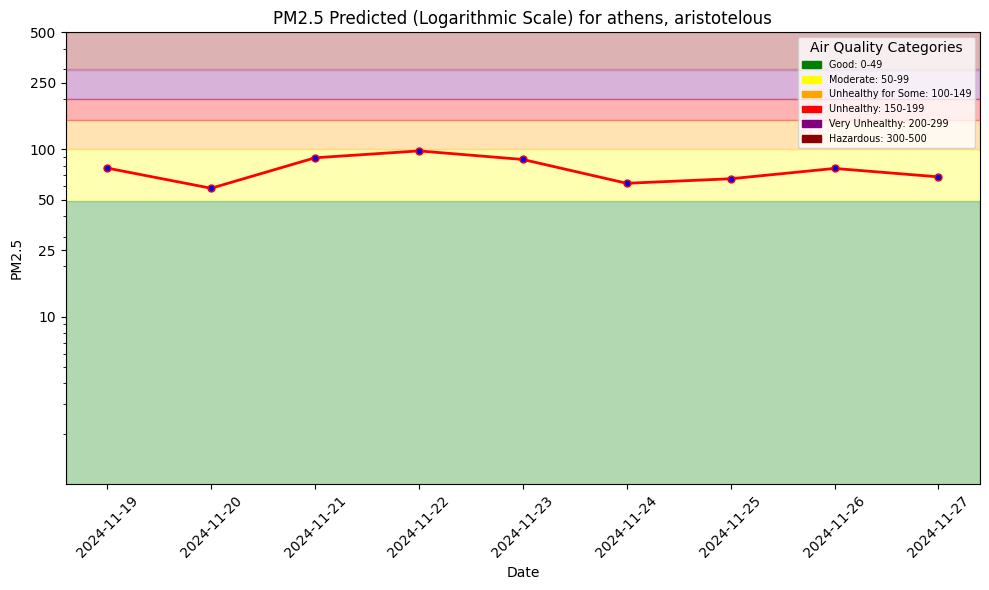

In [15]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [16]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_with_lagged',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [17]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_with_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1164448/jobs/named/aq_predictions_with_lagged_1_offline_fg_materialization/executions


KeyboardInterrupt: 

In [18]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lagged_pm25,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,6.350000,0.0,19.839235,281.513794,athens,50.000000,75.364693,aristotelous,greece,1
1,2024-11-18 00:00:00+00:00,8.000000,0.0,6.214563,280.007904,athens,9.000000,35.434772,aristotelous,greece,1
2,2024-11-04 00:00:00+00:00,15.572083,0.4,16.368128,60.629417,athens,63.666667,54.152004,aristotelous,greece,1
3,2024-11-15 00:00:00+00:00,8.800000,0.0,12.313894,322.124969,athens,55.000000,63.364433,aristotelous,greece,1
4,2024-11-07 00:00:00+00:00,19.701250,3.2,15.725037,57.853561,athens,48.000000,55.386837,aristotelous,greece,1
5,2024-10-31 00:00:00+00:00,19.570002,0.0,11.931705,137.701508,athens,65.666667,75.542358,aristotelous,greece,1
6,2024-11-01 00:00:00+00:00,19.253334,0.2,11.013882,198.986618,athens,111.333333,74.026520,aristotelous,greece,1
7,2024-11-03 00:00:00+00:00,17.907499,0.0,16.144905,67.883018,athens,108.333333,55.663223,aristotelous,greece,1
8,2024-11-06 00:00:00+00:00,19.482500,3.8,12.232057,73.531189,athens,57.000000,63.537315,aristotelous,greece,1
9,2024-11-16 00:00:00+00:00,6.100000,0.0,1.835647,348.690094,athens,9.000000,161.915222,aristotelous,greece,1


In [19]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_with_lagged',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df.sort_values(by="date")

air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.51s) 


,date,pm25,country,city,street,url,lagged_pm25
0,2021-12-11 00:00:00+00:00,52.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,56.333333
1,2021-02-20 00:00:00+00:00,104.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,106.666667
2,2023-11-02 00:00:00+00:00,58.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,67.000000
3,2024-04-23 00:00:00+00:00,72.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,44.666667
4,2021-01-01 00:00:00+00:00,67.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,38.333333
...,...,...,...,...,...,...,...
1775,2024-11-14 00:00:00+00:00,74.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,67.000000
1776,2024-11-11 00:00:00+00:00,39.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,48.333333
1777,2024-11-09 00:00:00+00:00,46.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,44.333333
1778,2024-11-08 00:00:00+00:00,49.0,greece,athens,aristotelous,https://api.waqi.info/feed/@12414,46.000000


In [26]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df:pd.DataFrame, monitor_fg, model, todays_lagged_pm_25):
    weather_df = weather_fg.read()
    features_df = weather_df.sort_values(by=['date'], ascending=True)
    features_df = pd.merge(features_df, air_quality_df, on=["date", 'city'])
    features_df = features_df.tail(10)
    features_df['predicted_pm25'] = model.predict(features_df[['lagged_pm25', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    # df = pd.merge(features_df, air_quality_df[['date',]], on="date")
    features_df['days_before_forecast_day'] = 1
    # hindcast_df = df
    # print("df", df.columns)
    # df = df.drop('pm25', axis=1)
    print(features_df.columns)
    monitor_data_columns = ["date", "temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant", "city", "lagged_pm25", "predicted_pm25", "street", "country", "days_before_forecast_day"]
    monitor_fg.insert(features_df[monitor_data_columns], write_options={"wait_for_job": True})
    return features_df

In [28]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

# Merge on date to see if there are available weather data for the predicted dates on the feature storage
hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, todays_lagged_pm_25)
hindcast_df

,date,predicted_pm25,pm25
4,2024-10-31 00:00:00+00:00,75.542358,204.0
5,2024-11-01 00:00:00+00:00,74.026520,56.0
10,2024-11-02 00:00:00+00:00,74.222229,65.0
6,2024-11-03 00:00:00+00:00,55.663223,70.0
1,2024-11-04 00:00:00+00:00,54.152004,47.0
9,2024-11-05 00:00:00+00:00,52.638248,54.0
7,2024-11-06 00:00:00+00:00,63.537315,43.0
3,2024-11-07 00:00:00+00:00,55.386837,41.0
2,2024-11-15 00:00:00+00:00,63.364433,82.0
8,2024-11-16 00:00:00+00:00,161.915222,39.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

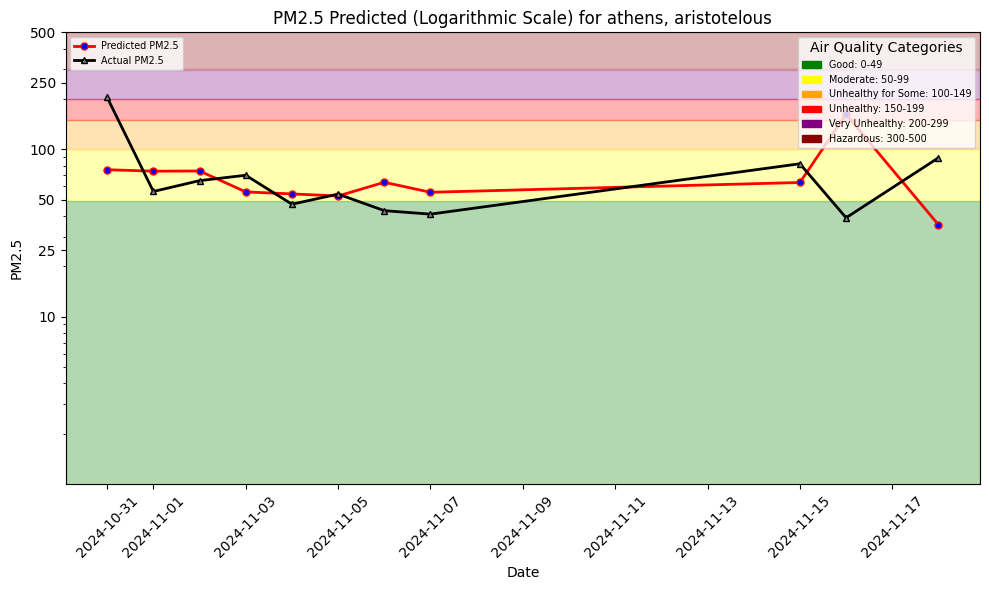

In [21]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---